# Phân loại bình luận tích cực và tiêu cực trên các quán ăn

In [64]:
import pandas as pd
import string
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import warnings as wrn
wrn.filterwarnings('ignore')

In [12]:
df = pd.read_csv('small_data.csv')
df['Label'] = df['Point'].apply(lambda point: 0 if point >= 6  else 1)
sentences = df['Review'].tolist()
joined_sentences = " ".join(sentences)

## Khai phá dữ liệu

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  1030 non-null   object 
 1   Point   1030 non-null   float64
 2   Label   1030 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 24.3+ KB


In [14]:
df.describe()

,Point,Label
count,1030.000000,1030.000000
mean,6.047184,0.407767
std,2.631097,0.491658
min,1.000000,0.000000
25%,4.000000,0.000000
50%,7.000000,0.000000
75%,8.000000,1.000000
max,10.000000,1.000000


<i>Dữ liệu trước khi tiền xử lý</i>

In [15]:
df

,Review,Point,Label
0,"Quán không gian không có địa điểm ăn tại chỗ, ...",4.4,1
1,mình có ord ở đây 2combo bánh mì tiêu đen + co...,2.0,1
2,"Đặt mỳ gà v mỳ bò về ăn, mỳ quảng ăn đ...",7.6,0
3,Hôm bữa đi ăn 2 phần bún đậu có gọi thêm sữa c...,1.0,1
4,Ăn tô mì cay mà thảm cảnh thật . Mì tôm việt n...,5.0,1
...,...,...,...
1025,"Nhân viên nhiệt tình, thân thiện, thức uống ng...",10.0,0
1026,"lăng mạ, chửi khách hàng. tự ý lấy hình của kh...",1.0,1
1027,"Dimsum không ngon, phục vụ ok. Giá cả chưa thậ...",4.8,1
1028,Mọi hôm hay ăn bông lan trứng muối gí cả ok rấ...,8.4,0


[Text(0.5, 1.0, 'Số lượng mẫu')]

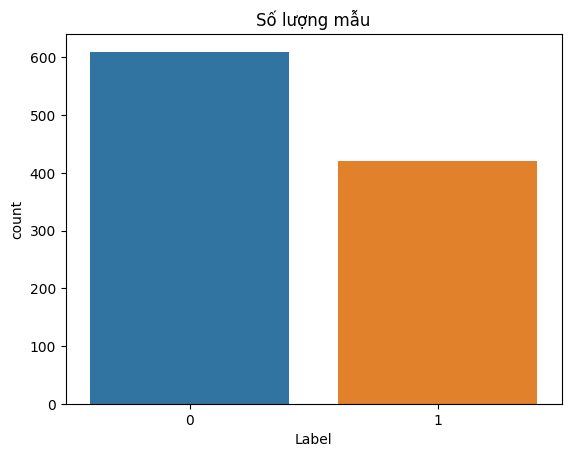

In [16]:
sns.countplot(data=df, x='Label').set(title='Số lượng mẫu')

### WordCloud trước khi tiền xử lý

In [84]:
def plot_wordcloud(sentences):
    plt.figure(figsize=(20, 20))
    wordcloud = WordCloud(max_words=200, background_color='white').generate(sentences)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


def plot_histogram(joined_sentences):
    # join các từ lại
    words_df = joined_sentences.split(sep=' ')

    # Tính số lượng từng từ có trong dataset
    words_df_dict = dict(Counter(words_df))
    words_df_dict = dict(sorted(words_df_dict.items(), key=lambda item: item[1], reverse=False))

    # plot 20 từ xuất hiện nhiều nhất
    histo = pd.DataFrame(words_df_dict.values(), index=words_df_dict.keys(), columns=['Count']).tail(20)
    histo.plot.barh()

- <i>Số lượng từ các văn bảng trong tập dữ liệu trước khi tiền xử lý</i>

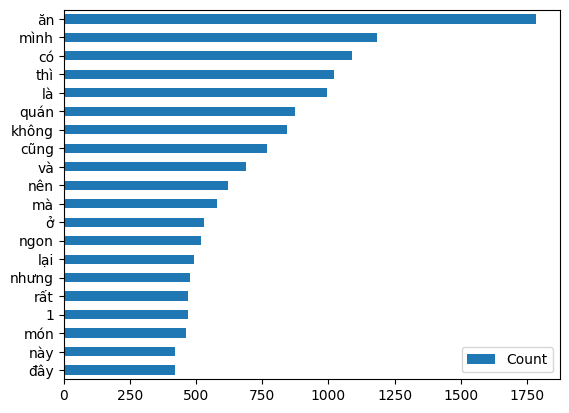

In [85]:
plot_histogram(joined_sentences)

- <i>WordCloud của tất cả các review</i>

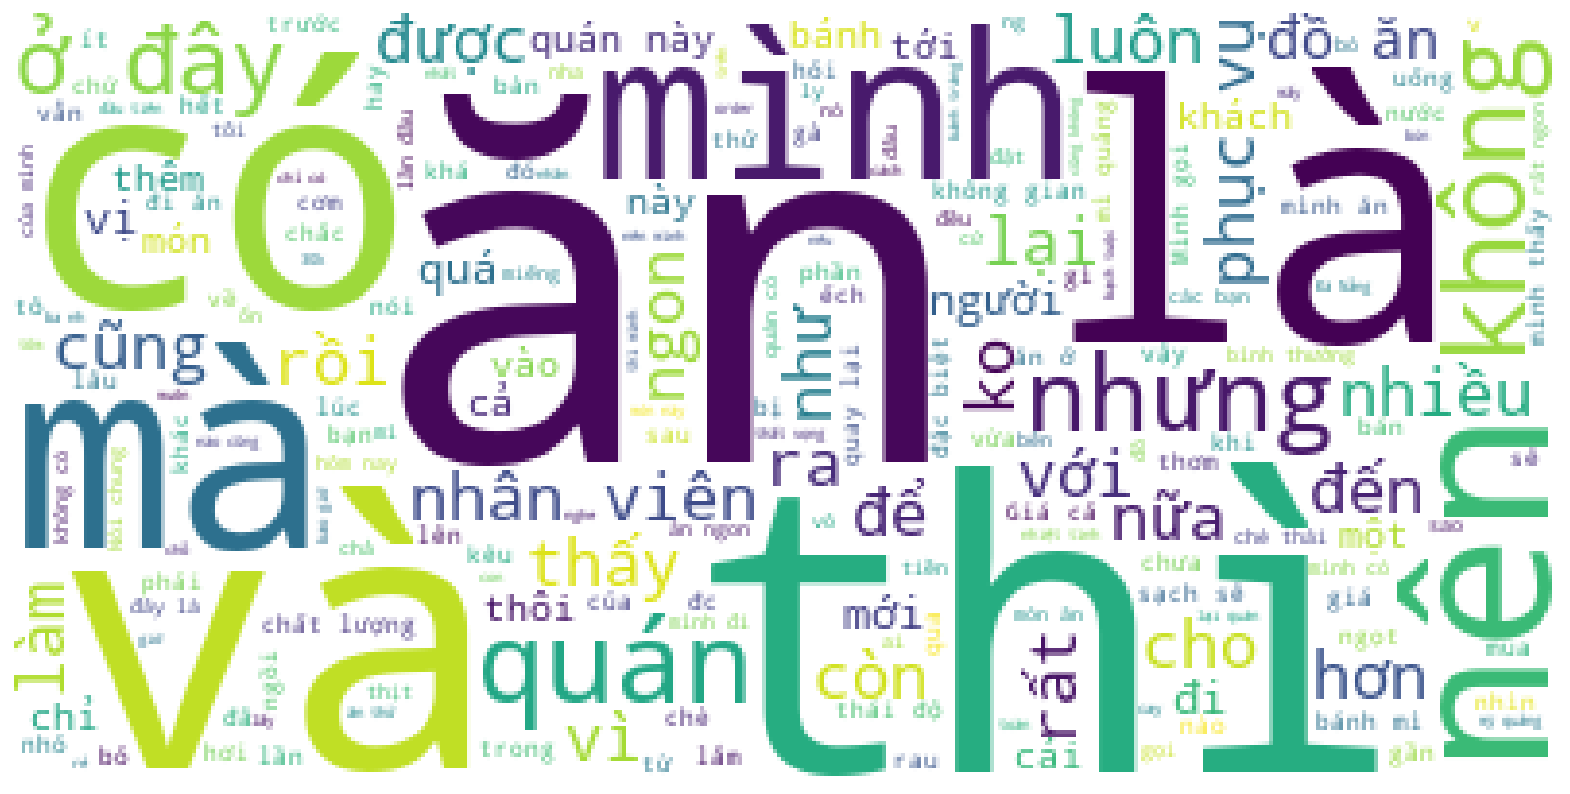

In [18]:
plot_wordcloud(joined_sentences)

In [19]:
negative = df[df['Label'] == 1]
positive = df[df["Label"] == 0]

negative_sentences = " ".join(negative['Review'].tolist())
positive_sentences = " ".join(positive['Review'].tolist())

- <i>WordCloud của các bình luận tiêu cực</i>

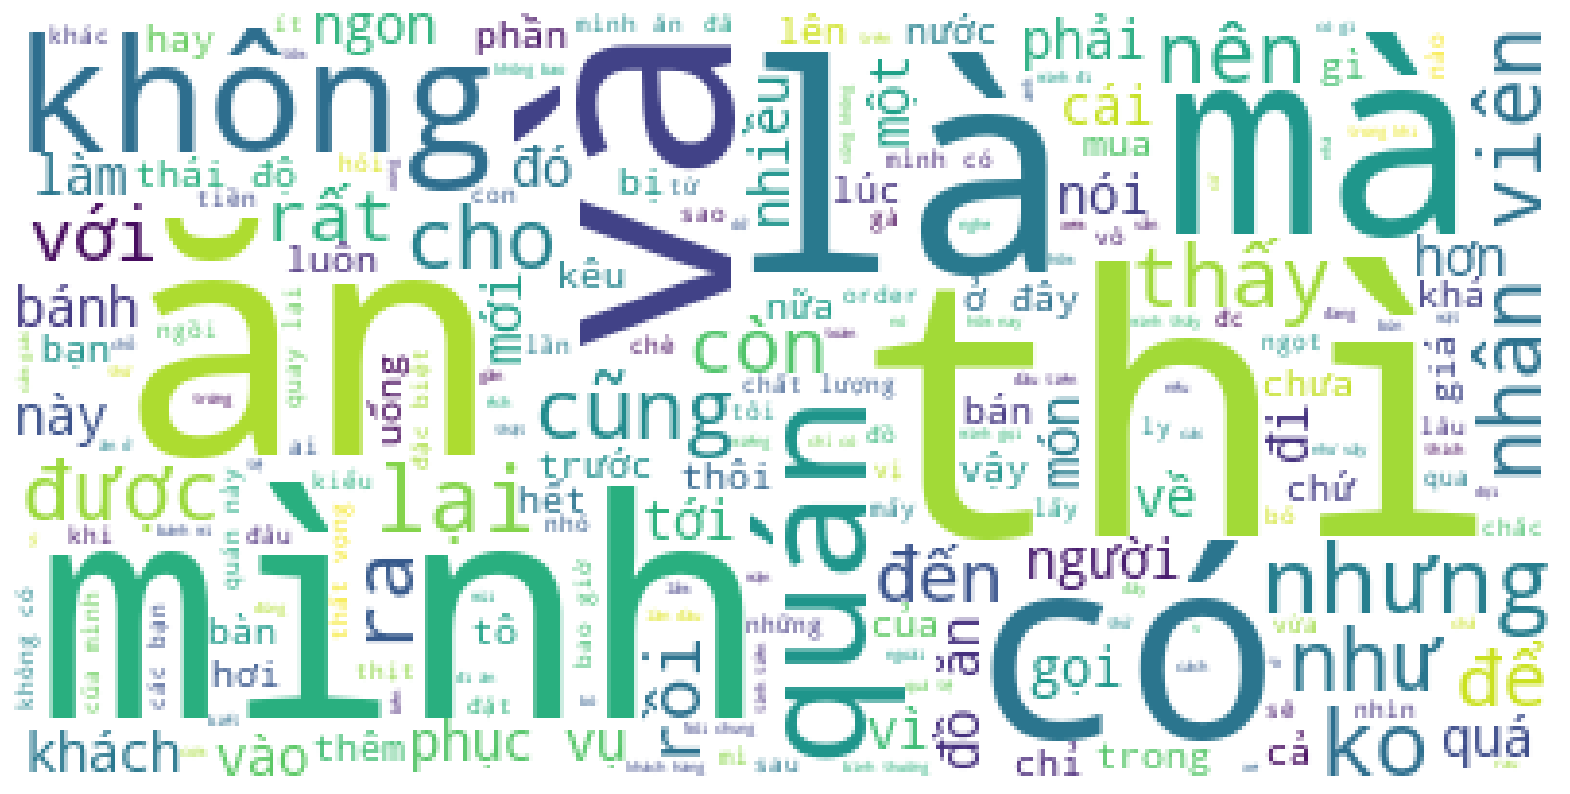

In [20]:
plot_wordcloud(negative_sentences)

- <i>WordCloud của các bình luận tích cực</i>

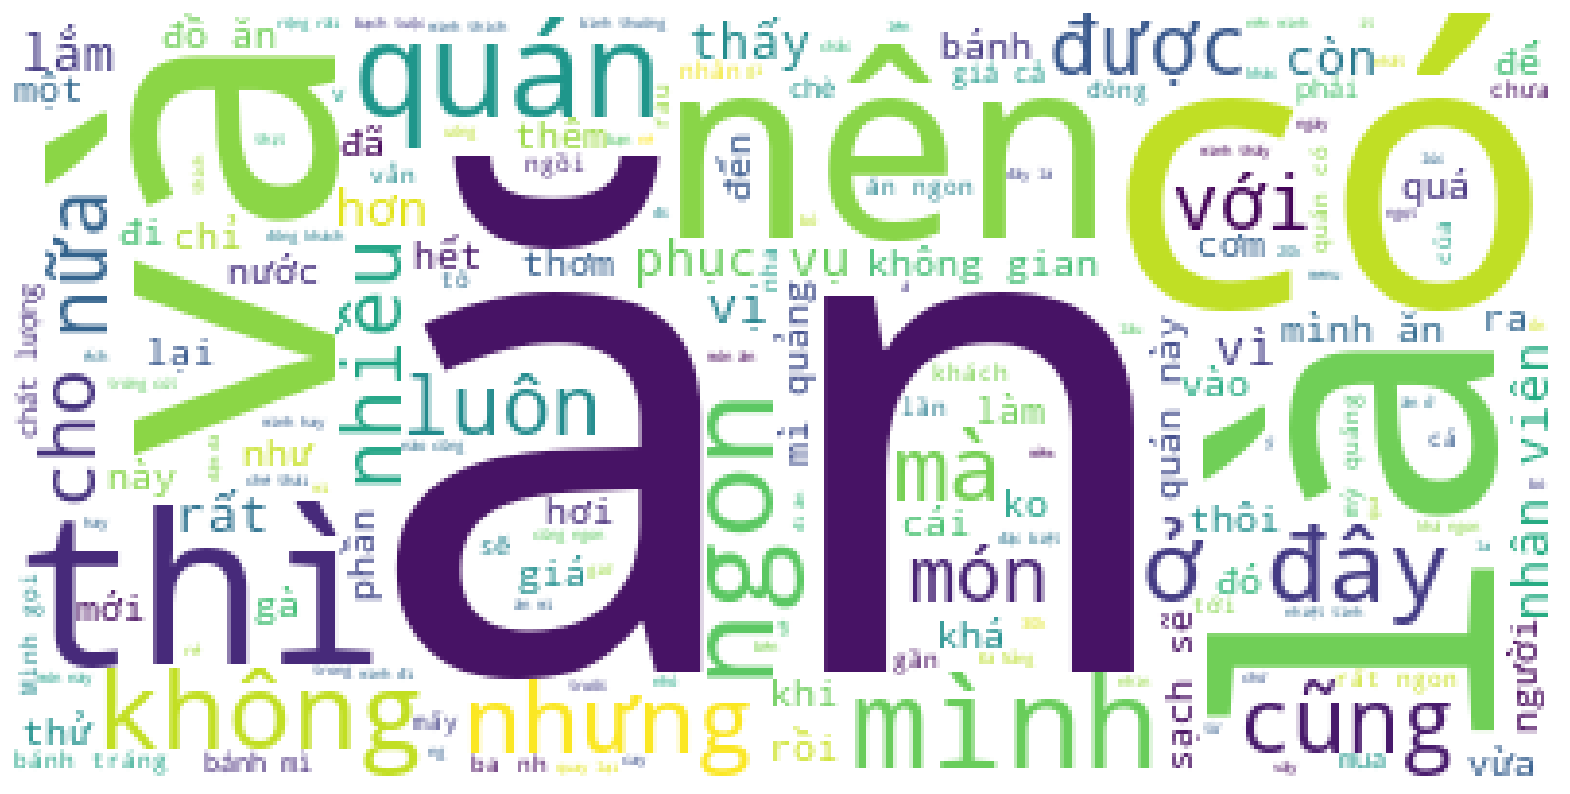

In [21]:
plot_wordcloud(positive_sentences)

### WordCloud sau khi tiền xử lý

Hàm tiền xử lý chuỗi

In [22]:
def tokenize_vietnamese_text(text):
    tokens = ViTokenizer.tokenize(text)
    return tokens


def get_stopwords(url):
    with open(url, 'r+', encoding='utf8') as file:
        stopwords = file.readlines()
        return set(stopwords)
    
    
stopwords = get_stopwords('vietnamese_stopwords_dash.txt')
def review_cleaning(message):
    # chuyển hết chuỗi sang chữ thường
    message = message.lower()
    
    # xoá các kí tự đặc biệt
    removed_punc_str = [char for char in message if char not in string.punctuation]
    removed_punc_str = ''.join(removed_punc_str)

    # tách các từ ghép
    removed_punc_str = tokenize_vietnamese_text(removed_punc_str)

    # xoá các stopwords
    clean_removed_punc_str = [word for word in removed_punc_str.split() if word.lower() not in stopwords]
    return clean_removed_punc_str

In [23]:
def list_to_str(message):
    return " ".join(message)

In [24]:
clean_df = pd.DataFrame(df['Review'].apply(review_cleaning))
clean_df['Review'] = clean_df['Review'].apply(list_to_str)
clean_df['Label'] = df['Label']

clean_sentences = " ".join(clean_df['Review'].tolist())

<i>Dữ liệu cột review sau khi tiền xử lý</i>

In [25]:
print(clean_df['Review'])

0       quán không_gian không có địa_điểm ăn tại_chỗ t...
1       mình có ord ở đây 2combo bánh_mì tiêu đen coca...
2       đặt mỳ gà v mỳ bò về ăn mỳ quảng_ăn được tô 25...
3       hôm bữa đi ăn 2 phần bún đậu có gọi thêm sữa_c...
4       ăn tô mì cay mà thảm_cảnh thật mì tôm việt_nam...
                              ...                        
1025    nhân_viên nhiệt_tình thân_thiện thức uống ngon...
1026    lăng_mạ chửi khách_hàng tự_ý lấy hình của khác...
1027    dimsum không ngon phục_vụ ok giá_cả chưa thật_...
1028    mọi hôm hay ăn bông lan trứng muối gí cả ok rấ...
1029    đến quán lúc 8h tối order 2 ly mang về sau đó ...
Name: Review, Length: 1030, dtype: object


- <i>Số lượng từ các văn bảng trong tập dữ liệu sau khi tiền xử lý</i>

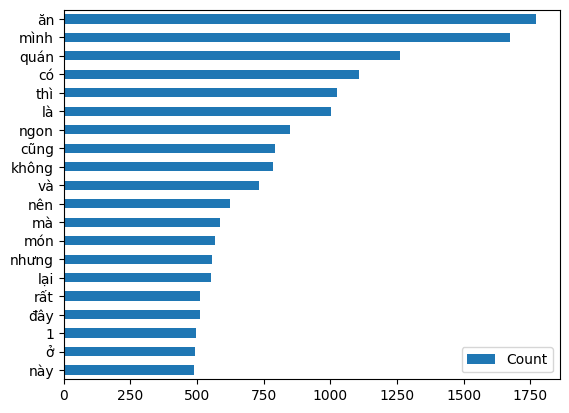

In [86]:
plot_histogram(clean_sentences)

- <i>WordCloud của tất cả các review</i>

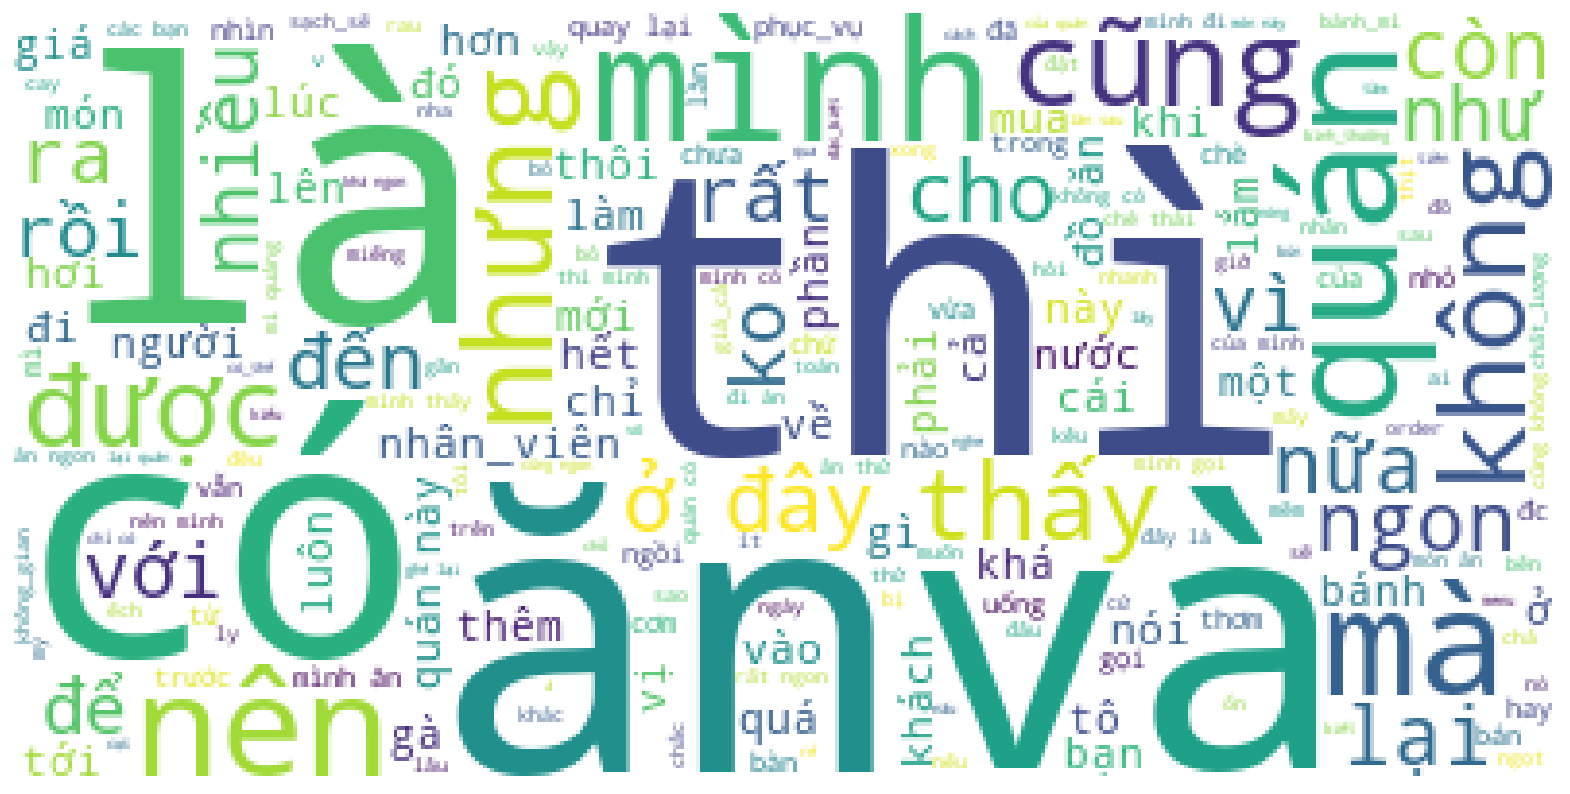

In [26]:
plot_wordcloud(clean_sentences)

In [27]:
clean_negative = clean_df[clean_df['Label'] == 1]
clean_positive = clean_df[clean_df['Label'] == 0]

clean_negative_sentences = " ".join(clean_negative['Review'].tolist())
clean_positive_sentences = " ".join(clean_positive['Review'].tolist())

- <i>WordCloud của các bình luận tiêu cực</i>

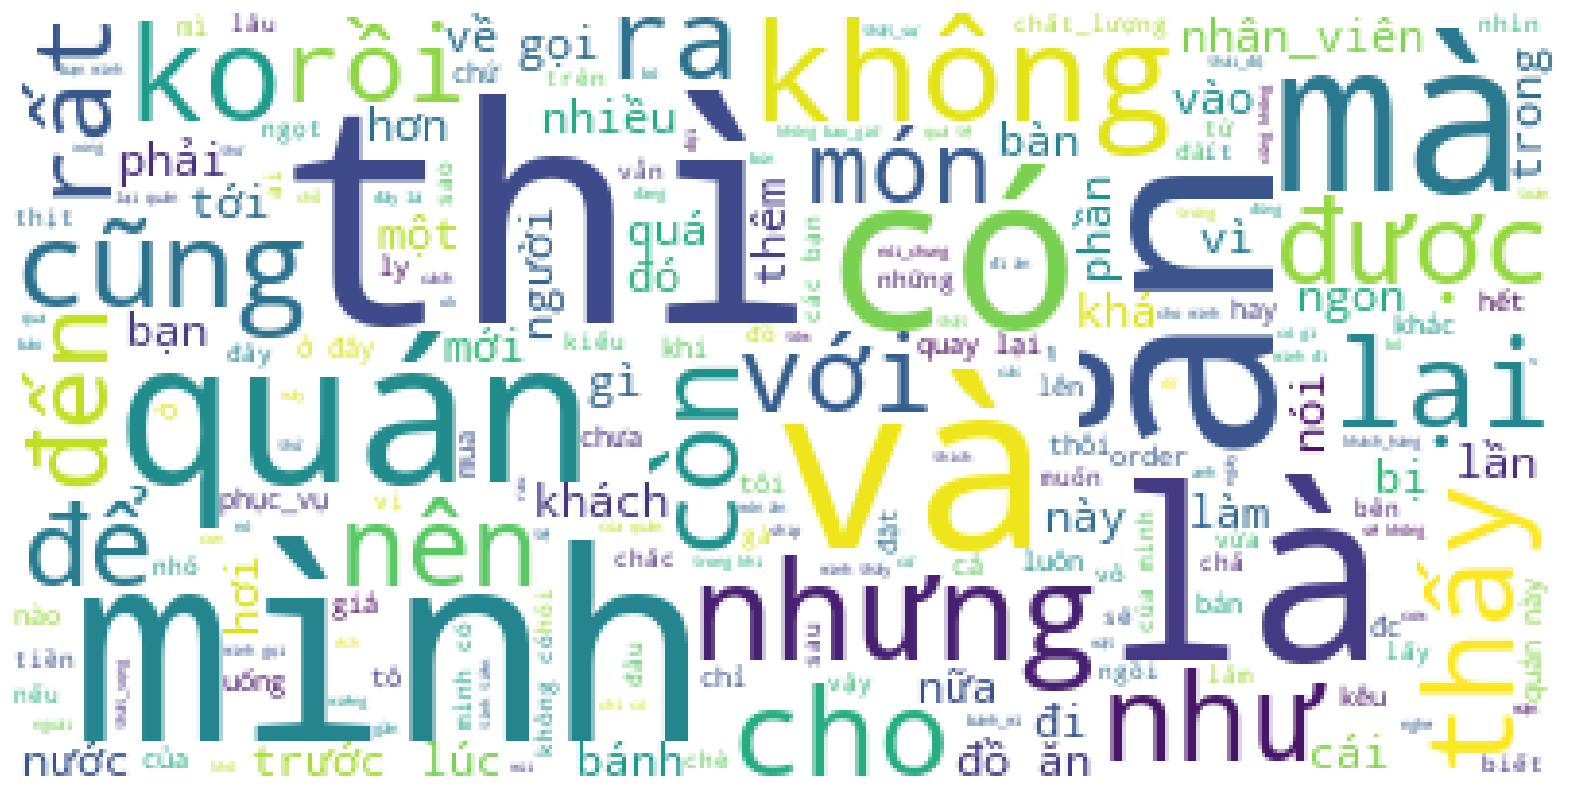

In [28]:
plot_wordcloud(clean_negative_sentences)

- <i>WordCloud của các bình luận tích cực</i>

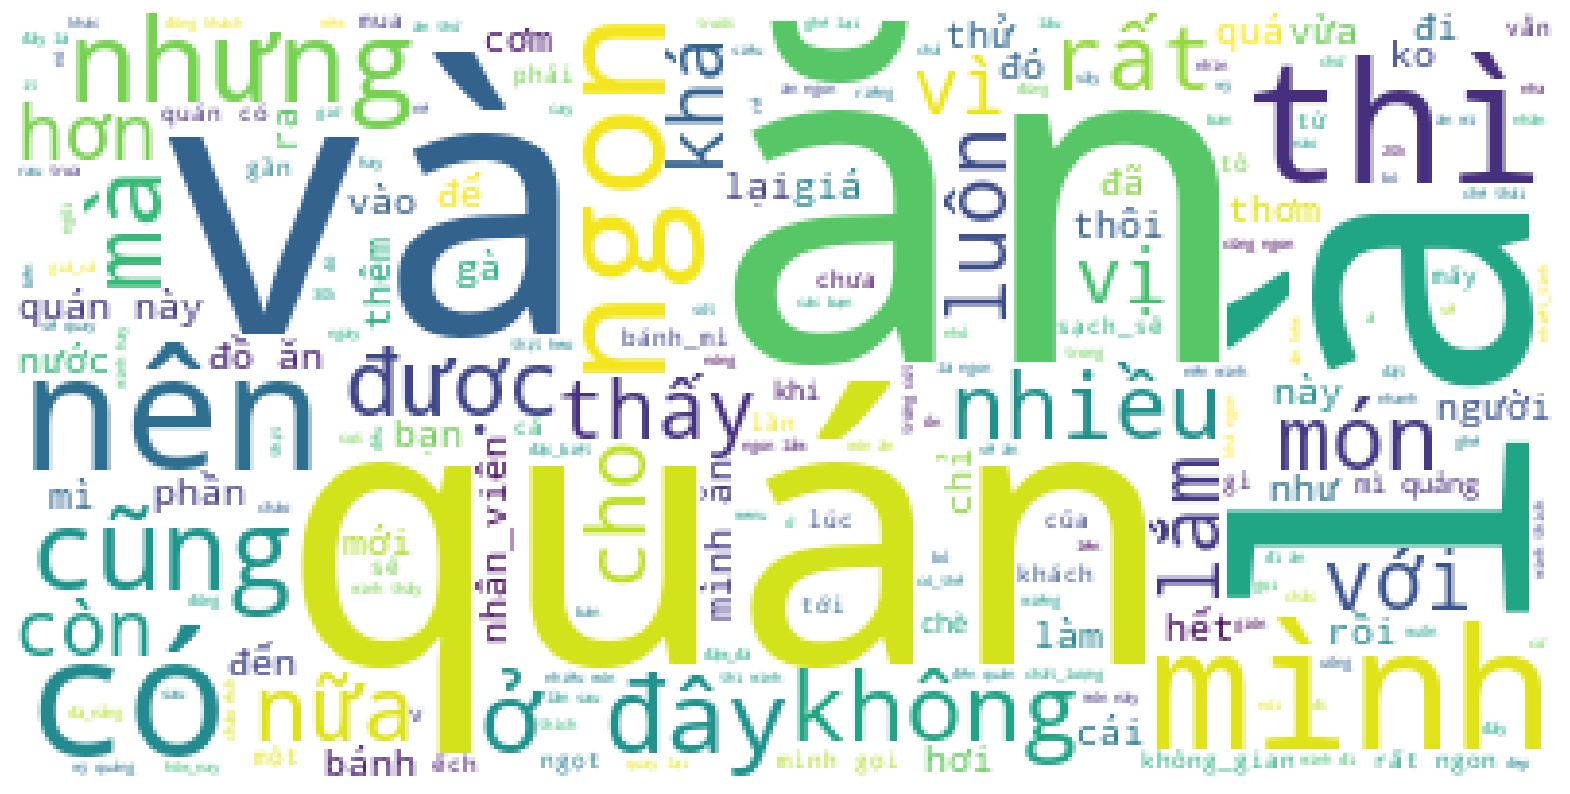

In [29]:
plot_wordcloud(clean_positive_sentences)

## Vector hoá văn bản và trực quan hoá dữ liệu

### CountVectorizer

<i>Áp dụng countvectorizer để vector hoá văn bản</i>
<br>
- Count_matrix có số chiều là 5063 (bằng với số từ vựng của tập dữ liệu vào)
- Count_matrix có số hàng là 1030 (bằng với số tập mẫu văn bản)

In [30]:
# Áp dụng vector
vectorizer = CountVectorizer(analyzer=review_cleaning)
count_matrix = vectorizer.fit_transform(df['Review'])
count_matrix

<1030x5063 sparse matrix of type '<class 'numpy.int64'>'
	with 53773 stored elements in Compressed Sparse Row format>

<i>Áp dụng t-SNE giảm chiều dữ liệu để trực quán hoá lên đồ thị 3 chiều</i>

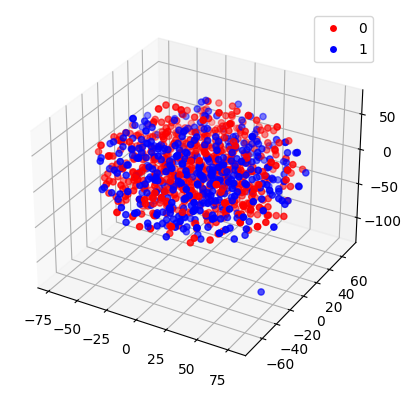

In [31]:
tsne = TSNE(n_components=3, random_state=42)
count_matrix_3d = tsne.fit_transform(count_matrix.toarray())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualize the data in 3D with colors based on the 'label' column
scatter = ax.scatter(count_matrix_3d[:, 0], count_matrix_3d[:, 1], count_matrix_3d[:, 2], c=df['Label'].map({0: 'red', 1: 'blue'}))

# Tạo legend cho nhãn
legend_labels = [0, 1]
legend_handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, label=label) for label, color in zip(legend_labels, ['red', 'blue'])]
ax.legend(handles=legend_handles, labels=legend_labels)

plt.show()

### TfidfVectorizer

<i>Áp dụng tfidfvectorizer để vector hoá văn bản</i>
<br>
- count_matrix có số chiều là 5063 (bằng với số từ vựng của tập dữ liệu vào)
- count_matrix có số hàng là 1030 (bằng với số tập mẫu văn bản)

In [32]:
# Create a CountVectorizer object and apply it to the 'review' column
vectorizer = TfidfVectorizer(analyzer=review_cleaning)
count_matrix = vectorizer.fit_transform(df['Review'])
count_matrix

<1030x5063 sparse matrix of type '<class 'numpy.float64'>'
	with 53773 stored elements in Compressed Sparse Row format>

<i>Áp dụng t-SNE giảm chiều dữ liệu để trực quán hoá lên đồ thị 3 chiều</i>

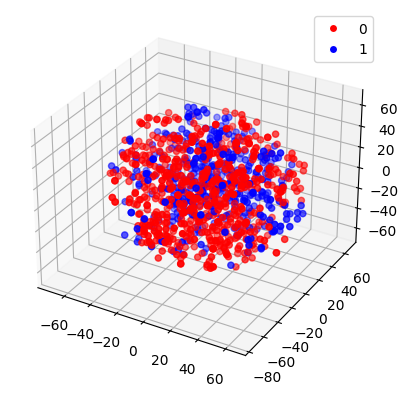

In [33]:

tsne = TSNE(n_components=3, random_state=42)
count_matrix_3d = tsne.fit_transform(count_matrix.toarray())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(count_matrix_3d[:, 0], count_matrix_3d[:, 1], count_matrix_3d[:, 2], c=df['Label'].map({0: 'red', 1: 'blue'}))

# Tạo legend cho nhãn
legend_labels = [0, 1]
legend_handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, label=label) for label, color in zip(legend_labels, ['red', 'blue'])]
ax.legend(handles=legend_handles, labels=legend_labels)

plt.show()

## Huấn luyện mô hình

In [34]:
def plot_confusion_matrix(x_test, y_test, model:GridSearchCV):
    # Dự đoán tập test
    y_pred = model.predict(x_test)

    # plot ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    print(classification_report(y_test, y_pred))


def train_model(vectorizer, classifier, x, y, cv=5):
    # Tạo pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # cross_validate để dự đoán độ chính xác khi train
    y_pred = cross_val_predict(pipeline, x, y, cv=cv)
    accu = accuracy_score(y, y_pred)
    print('Accuracy score: {}'.format(accu))
    # cm = confusion_matrix(y, y_pred)
    # sns.heatmap(cm, annot=True, fmt='d')
    # print(classification_report(y, y_pred))
    return pipeline.fit(x, y)


def train_model_with_hyperparameters(vectorizer, classifier, x, y, cv=5):
    # Tạo pipeline
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    # Kiểm tra mô hình chọn để lựa chọn đúng bộ siêu tham số
    if isinstance(classifier, MultinomialNB):
        para_grid = {
            'classifier__alpha': [0.1, 0.5, 1.0],
            'classifier__fit_prior': [True, False]
        }
        columns = ['rank_test_score', 'mean_test_score', 'param_classifier__alpha','param_classifier__fit_prior']
    # thêm hyperparameters sau tuỳ theo mô hình lựa chọn
    else:
        para_grid = {
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': [1.0, 0.1, 0.01, 0.001]
        }
        columns = ['rank_test_score', 'mean_test_score', 'param_classifier__penalty','param_classifier__C']

    # Tìm kiếm bộ tham số tối ưu cho mô hình
    grid_search = GridSearchCV(pipeline, param_grid=para_grid, scoring='accuracy', cv=cv)

    search_result = grid_search.fit(x, y)
    result = pd.DataFrame(search_result.cv_results_, columns=columns).sort_values(by='rank_test_score')
    print("Best score: {} with hyperparameters {}".format(search_result.best_score_, search_result.best_params_))

    # Trả về kết quả, lần lượt và mô hình đã train và kết quả khi train với từng bộ tham số
    return search_result, result

### Huấn luyện trên small data

In [35]:
# Đọc dữ liệu từ small data
small_df = pd.read_csv('small_data.csv')
small_df['Label'] = small_df['Point'].apply(lambda point: 0 if point >= 6 else 1)
x = small_df['Review']
y = small_df['Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

#### Mô hình Naive Bayes

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [36]:
train_model(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.8821081830790569


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x0000023227A24310>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [37]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.8890325670498085 with hyperparameters {'classifier__alpha': 0.5, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
3,1,0.889033,0.5,False
2,2,0.884895,0.5,True
1,3,0.884885,0.1,False
0,4,0.883506,0.1,True
5,4,0.883506,1.0,False


<b><i>Nhận xét</i></b>: Bằng cách lựa chọn siêu tham số thì độ chính xác của thuật toán tăng 1,45%, từ 91,16 lên 92,61% 

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       183
           1       0.88      0.76      0.82       126

    accuracy                           0.86       309
   macro avg       0.87      0.85      0.85       309
weighted avg       0.86      0.86      0.86       309



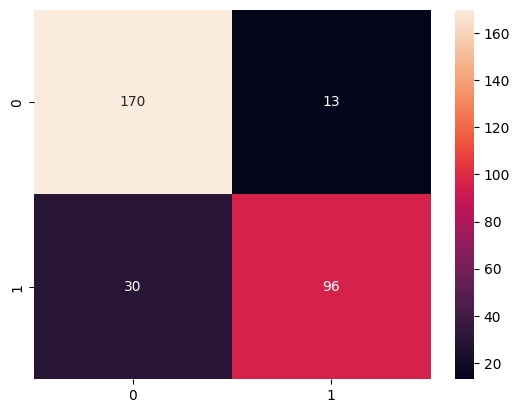

In [38]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [39]:
train_model(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.7558945908460472


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x0000023227A24310>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [40]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.886264367816092 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
1,1,0.886264,0.1,False
0,2,0.877950,0.1,True
3,3,0.866849,0.5,False
2,4,0.828027,0.5,True
5,5,0.823860,1.0,False


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.86      0.93      0.90       183
           1       0.89      0.79      0.84       126

    accuracy                           0.87       309
   macro avg       0.88      0.86      0.87       309
weighted avg       0.88      0.87      0.87       309



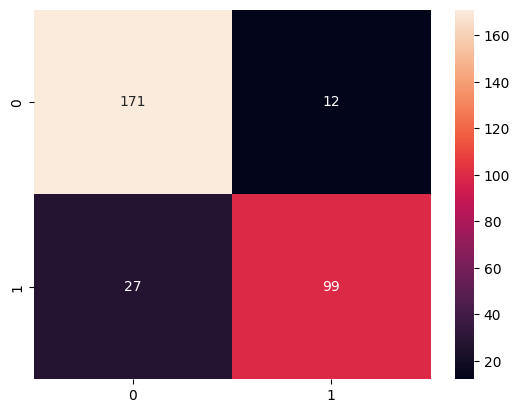

In [41]:
plot_confusion_matrix(x_test, y_test, model)

#### Mô hình Support Vector Machine

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [42]:
train_model(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.8169209431345353


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x0000023227A24310>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [43]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.8682471264367816 with hyperparameters {'classifier__C': 0.01, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
5,1,0.868247,l2,0.01
7,2,0.851638,l2,0.001
3,3,0.836379,l2,0.1
2,4,0.827989,l1,0.1
0,5,0.822462,l1,1.0


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       183
           1       0.87      0.79      0.82       126

    accuracy                           0.86       309
   macro avg       0.86      0.85      0.86       309
weighted avg       0.86      0.86      0.86       309



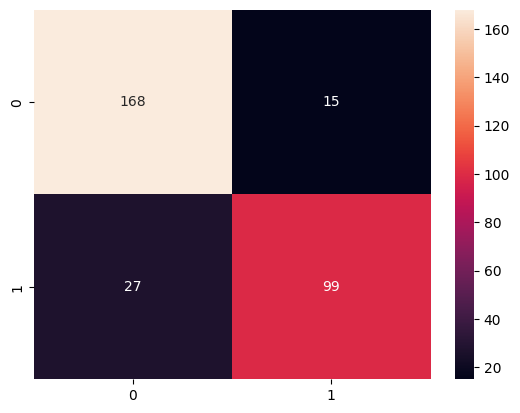

In [44]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [45]:
train_model(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.8807212205270458


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x0000023227A24310>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [46]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.8821360153256705 with hyperparameters {'classifier__C': 0.1, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
3,1,0.882136,l2,0.1
1,2,0.880747,l2,1.0
0,3,0.846054,l1,1.0
2,4,0.669923,l1,0.1
5,5,0.595000,l2,0.01


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       183
           1       0.92      0.74      0.82       126

    accuracy                           0.87       309
   macro avg       0.88      0.85      0.86       309
weighted avg       0.87      0.87      0.86       309



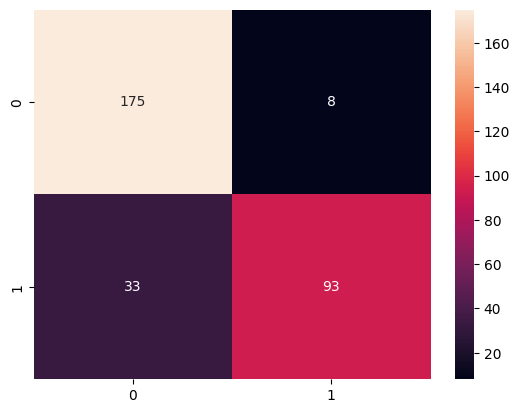

In [47]:
plot_confusion_matrix(x_test, y_test, model)

### Huấn luyện trên big data

In [48]:
# Đọc dữ liệu từ small data
big_df = pd.read_csv('big_data.csv')
big_df['Label'] = big_df['Point'].apply(lambda point: 0 if point >= 6 else 1)
x = big_df['Review']
y = big_df['Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

[Text(0.5, 1.0, 'Số lượng mẫu')]

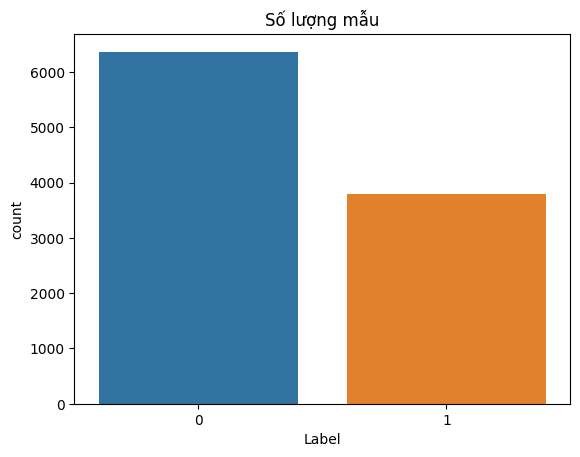

In [61]:
sns.countplot(data=big_df, x='Label').set(title='Số lượng mẫu')

#### Mô hình Naive Bayes

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [49]:
train_model(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.9126281781149038


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x0000023227A24310>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [50]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.9255514343016416 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
1,1,0.925551,0.1,False
0,2,0.923866,0.1,True
3,3,0.919512,0.5,False
2,4,0.916983,0.5,True
5,5,0.916141,1.0,False


<b><i>Nhận xét</i></b>: Bằng cách lựa chọn siêu tham số thì độ chính xác của thuật toán tăng 1,45%, từ 91,16 lên 92,61% 

###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1911
           1       0.95      0.88      0.91      1140

    accuracy                           0.94      3051
   macro avg       0.94      0.93      0.93      3051
weighted avg       0.94      0.94      0.94      3051



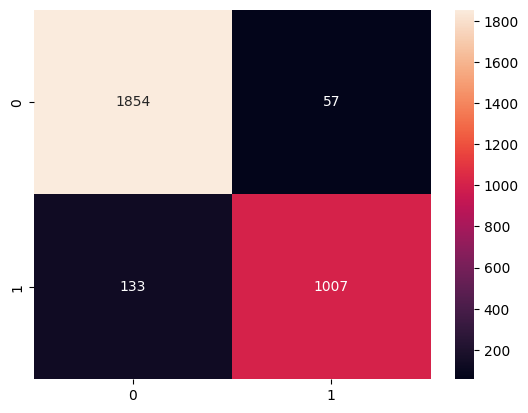

In [51]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [52]:
train_model(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)

Accuracy score: 0.8627616238235707


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x0000023227A24310>)),
                ('classifier', MultinomialNB())])

###### Có dùng hyperparameters

In [53]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), MultinomialNB(), x_train, y_train)
result.head()

Best score: 0.9322945865279083 with hyperparameters {'classifier__alpha': 0.1, 'classifier__fit_prior': False}


,rank_test_score,mean_test_score,param_classifier__alpha,param_classifier__fit_prior
1,1,0.932295,0.1,False
0,2,0.925412,0.1,True
3,3,0.919231,0.5,False
2,4,0.899426,0.5,True
5,5,0.898863,1.0,False


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1911
           1       0.94      0.90      0.92      1140

    accuracy                           0.94      3051
   macro avg       0.94      0.93      0.94      3051
weighted avg       0.94      0.94      0.94      3051



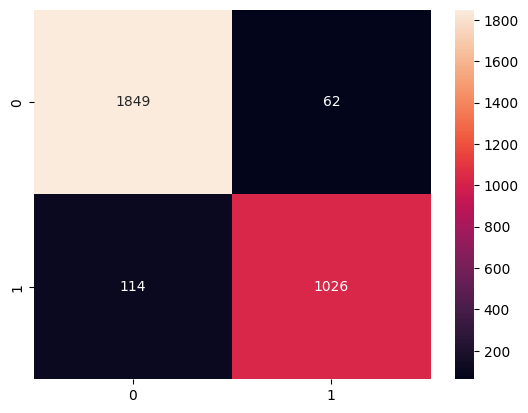

In [54]:
plot_confusion_matrix(x_test, y_test, model)

#### Mô hình Support Vector Machine

##### CountVectorizer làm input

###### Không dùng hyperparameters

In [55]:
train_model(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.950976260710774


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function review_cleaning at 0x0000023227A24310>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [56]:
model, result = train_model_with_hyperparameters(CountVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.953927057095707 with hyperparameters {'classifier__C': 0.1, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
3,1,0.953927,l2,0.1
0,2,0.952382,l1,1.0
1,3,0.950978,l2,1.0
5,4,0.938336,l2,0.01
2,5,0.930189,l1,0.1


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1911
           1       0.96      0.95      0.95      1140

    accuracy                           0.97      3051
   macro avg       0.96      0.96      0.96      3051
weighted avg       0.97      0.97      0.97      3051



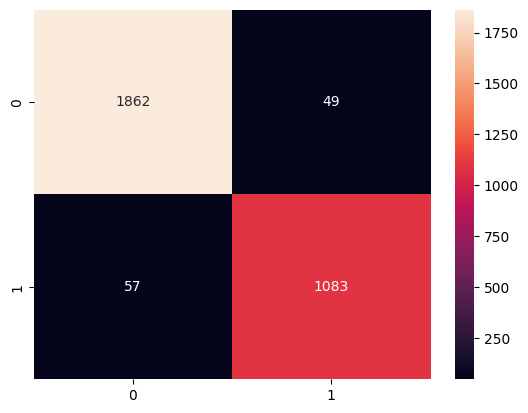

In [57]:
plot_confusion_matrix(x_test, y_test, model)

##### TfidfVectorizer làm input

###### Không dùng hyperparameters

In [58]:
train_model(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)

Accuracy score: 0.9570164348925411


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer=<function review_cleaning at 0x0000023227A24310>)),
                ('classifier', LinearSVC(dual=False))])

###### Có dùng hyperparameters

In [59]:
model, result = train_model_with_hyperparameters(TfidfVectorizer(analyzer=review_cleaning), LinearSVC(dual=False), x_train, y_train)
result.head()

Best score: 0.957017339534296 with hyperparameters {'classifier__C': 1.0, 'classifier__penalty': 'l2'}


,rank_test_score,mean_test_score,param_classifier__penalty,param_classifier__C
1,1,0.957017,l2,1.0
0,2,0.944235,l1,1.0
3,3,0.932154,l2,0.1
2,4,0.878354,l1,0.1
5,5,0.863887,l2,0.01


###### Kiểm thử trên tập test

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1911
           1       0.97      0.95      0.96      1140

    accuracy                           0.97      3051
   macro avg       0.97      0.96      0.97      3051
weighted avg       0.97      0.97      0.97      3051



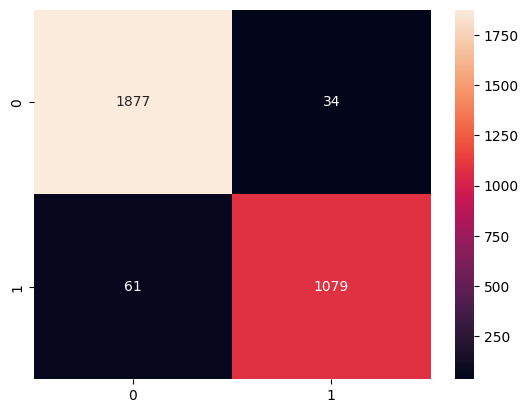

In [60]:
plot_confusion_matrix(x_test, y_test, model)